### Importar Librerias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Cargar los datos

In [13]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
submission_path = 'data/sample_submission.csv'

In [14]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

### Exploración inicial

In [15]:
def explore_data(df, name):
    print(f'\n{name} Dataset Info:')
    print(df.info())
    print('\nDescripción estadística:')
    print(df.describe())
    print('\nValores nulos:')
    print(df.isnull().sum())
    print('\nDuplicados:', df.duplicated().sum())

explore_data(train, "Train")
explore_data(test, "Test")


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    object 
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    object 
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 92.8+ KB
None

Descripción estadística:
         laptop_ID      Inches  Price_in_euros
count   912.000000  912.000

### Visualización de distribuciones

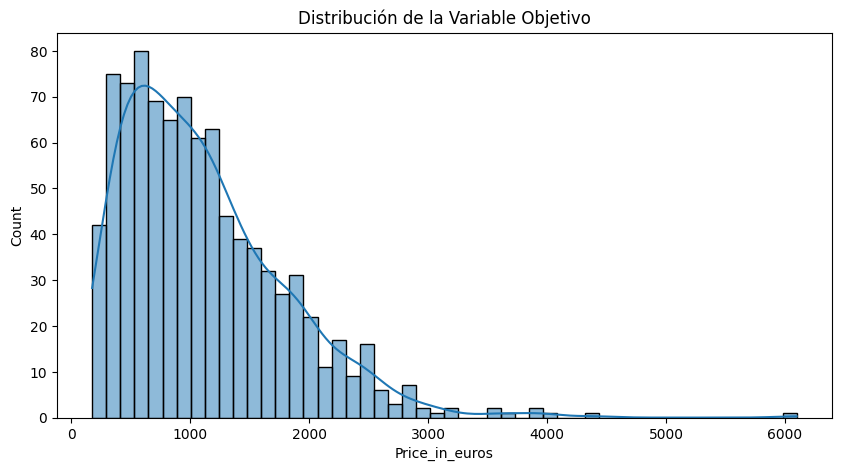

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(train.iloc[:, -1], bins=50, kde=True)
plt.title("Distribución de la Variable Objetivo")
plt.show()

### Matriz de correlación

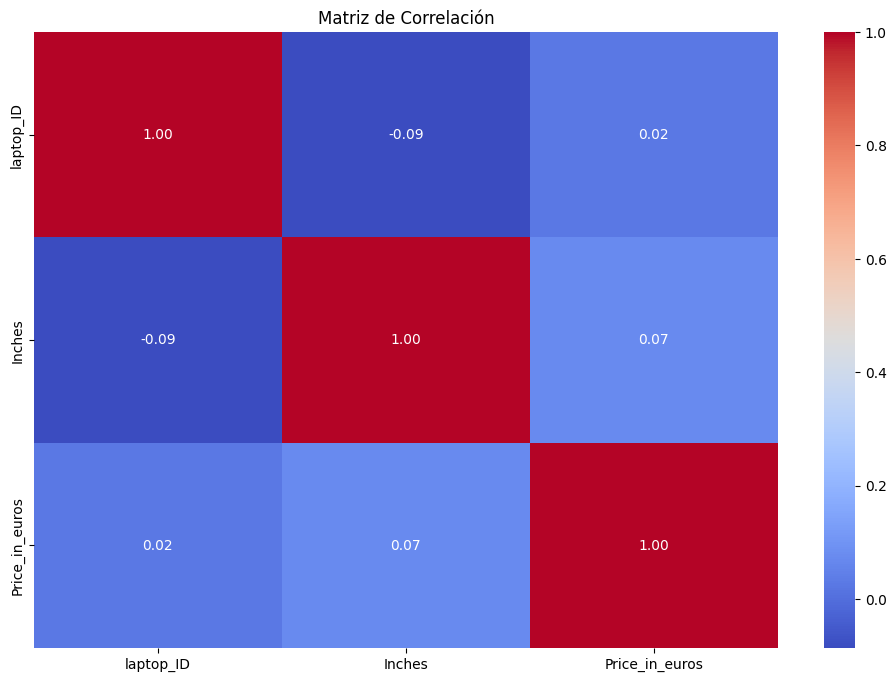

In [17]:
# Select only numeric columns
numeric_train = train.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### Valores nulos visualizados

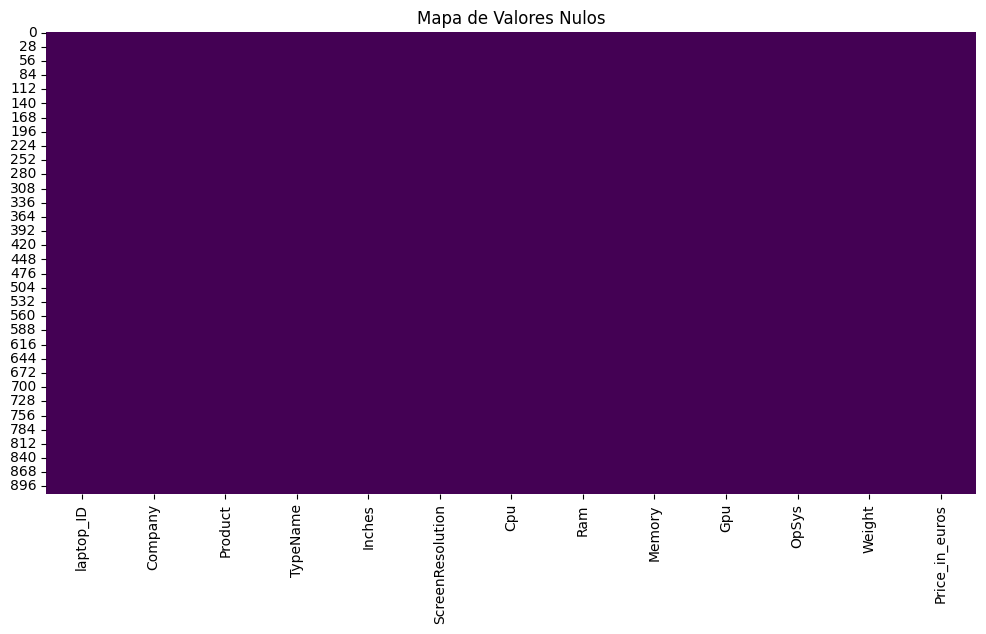

In [18]:
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Valores Nulos")
plt.show()

### Conteo de categorías si hay variables categóricas

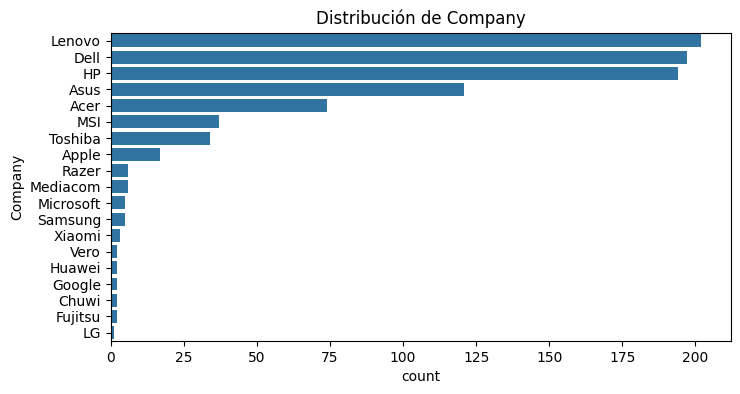

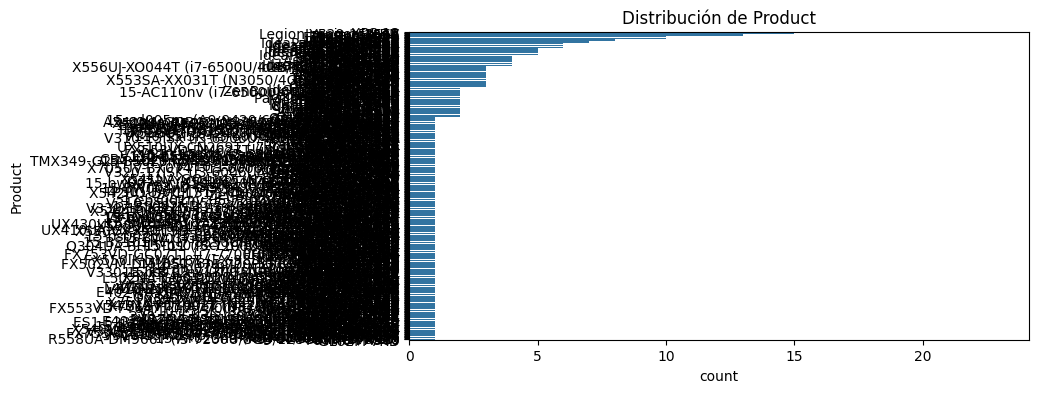

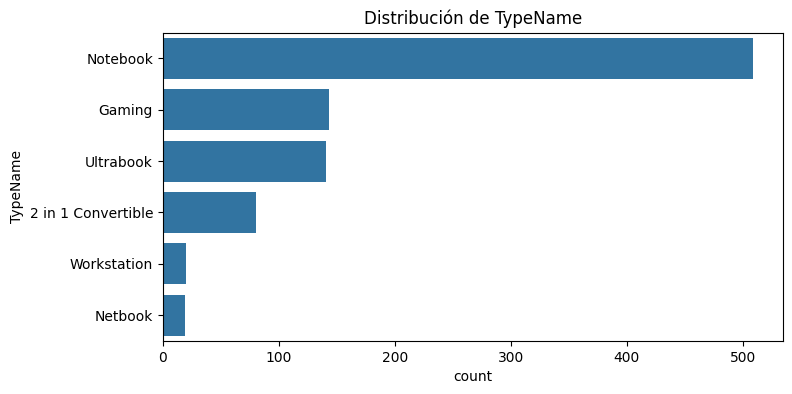

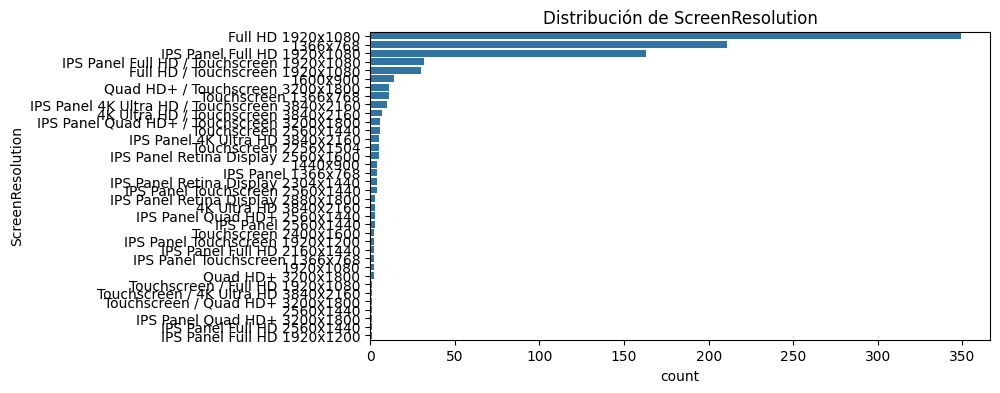

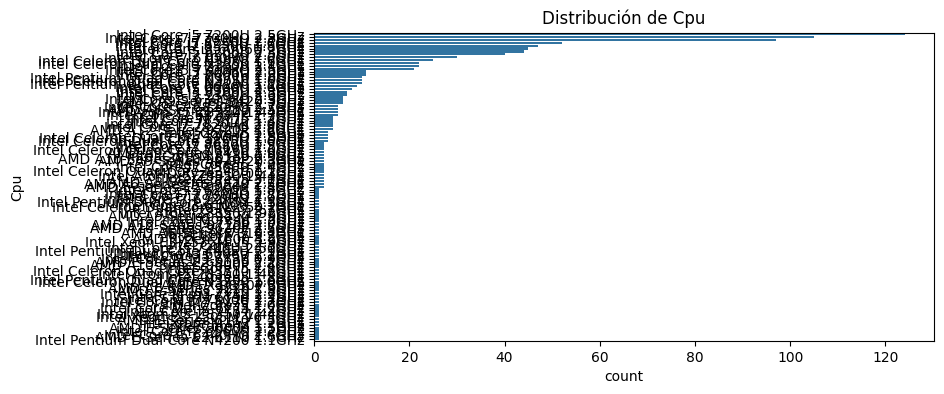

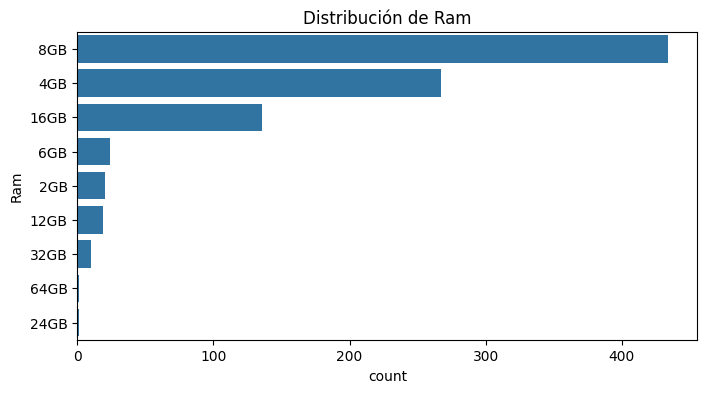

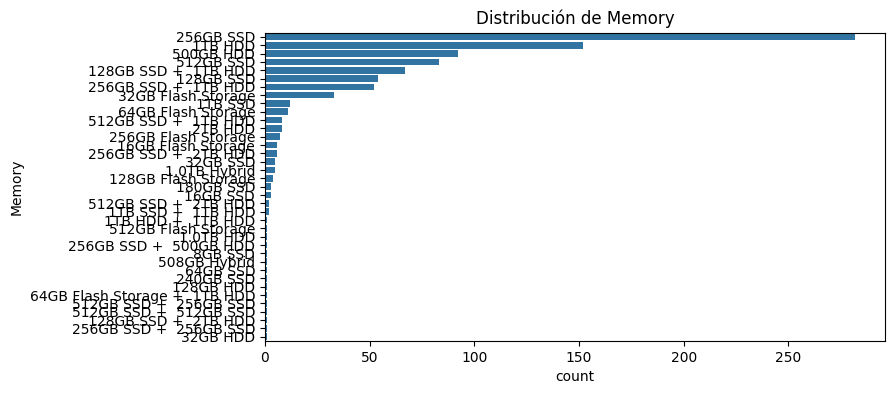

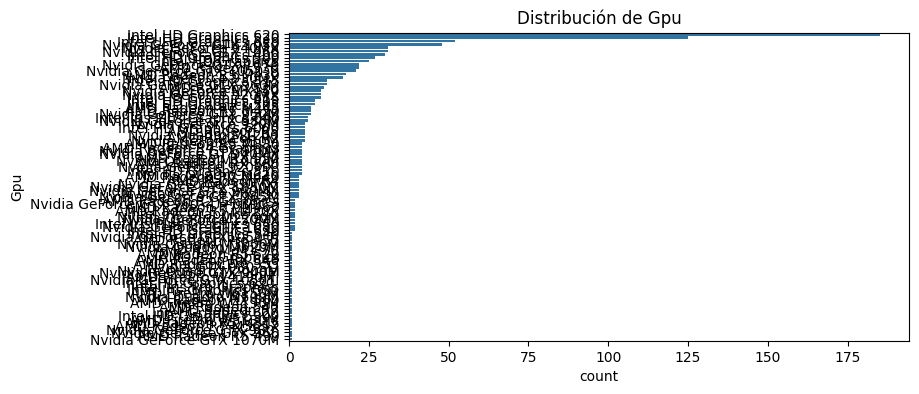

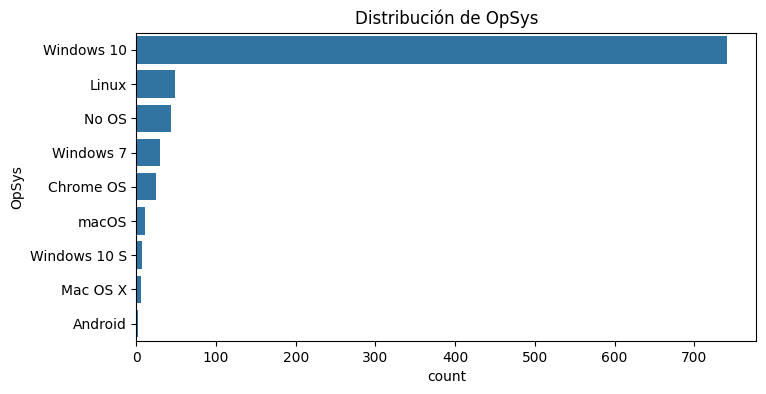

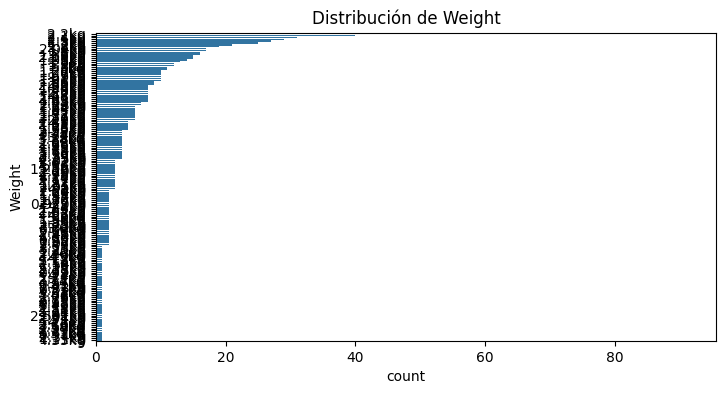

In [19]:
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train[col], order=train[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.show()